# 流计算

dask的实时任务提交接口非常适合做流处理,通过结合[streamz](https://github.com/python-streamz/streamz)我们可以构造复杂的流处理系统.


流处理常用于处理数据流,构造数据处理管道.具体的内容我们后面数据科学部分再说.

## 使用streamz做流处理

streamz的基本接口主要有如下几类:

###  基本的的流处理结构

+ `map(upstream, func, *args, **kwargs)`用于将流中的每个数据分发给处理函数;
+ `Stream.emit(self, x[, asynchronous])`用于将数据提交到流;
+ `sink(upstream, func, *args, **kwargs)`则将函数应用于每个结果.

一个最简单最基本的流处理单元如下:

In [2]:
from streamz import Stream

def increment(x):
    return x**2 + 1

source = Stream()
source.map(increment).sink(print)

for i in range(10):
    source.emit(i)

1
2
5
10
17
26
37
50
65
82


### 设置缓冲区防止流堵塞

由于机器的性能或者短时间内大量数据的涌入,流处理可能会堵塞,我们可以使用`buffer(upstream, n, **kwargs)`来设置一个缓冲区,以应付这种情况.在上一个节点未能处理完之前如果有新的节点进来,那么它会被放在缓冲区.

In [2]:
from streamz import Stream

def increment(x):
    return x**2 + 1

source = Stream()
source.buffer(100).map(increment).sink(print)

for i in range(10):
    source.emit(i)

1
2
5
10
17
26
37
50
65
82


### 积累状态

使用接口`accumulate(upstream, func[, start, …])`可以积累流中的状态,类似`reduce`操作

In [3]:
from streamz import Stream

def increment(x):
    return x**2 + 1

def add(x,y):
    return x+y

source = Stream()
source.map(increment).accumulate(add).sink(print)

for i in range(10):
    source.emit(i)

1
3
8
18
35
61
98
148
213
295


### 操作流中元素

+ 确保唯一性

可以使用`unique(upstream[, maxsize, key, hashable])`保证流中元素唯一性,这个接口可以设置`maxsize`参数 用于控制这个唯一性的范围(最近多少条没有重复),重复的元素则会被过滤掉;而参数`key`和python中其他itertools一样用于确定不重复的键如何取到.

In [7]:
source = Stream()
#source.unique(maxsize=1).sink(print)
source.unique(maxsize=4).sink(print)
for i in [1,2,3,2,3,2,2,4,5,6]:
    source.emit(i)
print("##################")
source = Stream()
source.unique(maxsize=1).sink(print)
for i in [1,2,3,2,3,2,2,4,5,6]:
    source.emit(i)

1
2
3
4
5
6
##################
1
2
3
2
3
2
4
5
6


+ 过滤元素

可以使用`filter(upstream, predicate, *args, **kwargs)`来主动过滤一些符合条件的元素.

In [5]:
source = Stream()
source.filter(lambda x: x%2 == 0).sink(print)
for i in range(10):
    source.emit(i)

0
2
4
6
8


+ 将流数据压扁

类似spark中的flatten,`flatten()`也是一个功能,

In [9]:
source = Stream()

source.flatten().sink(print)

for i in [[1, 2, 3], [4, 5], [6, 7, 7]]:
    source.emit(i)

1
2
3
4
5
6
7
7


+ 延迟处理

借助事件循环,我们可以使用`delay(upstream, interval, **kwargs)`接口来推迟执行的时间.

In [6]:
source = Stream()
source.delay(1).filter(lambda x: x%2 == 0).sink(print)
for i in range(10):
    source.emit(i)

0
2
4
6
8


+ 固定时间间隔执行

`rate_limit(upstream, interval, **kwargs)`可以实现这个功能,它可以用于平稳流的执行.

In [6]:
import time
source = Stream()
source.rate_limit(interval=1).sink(print)
for i in range(10):
    source.emit(i)

0
1
2
3
4
5
6
7
8
9


### 截断缓存流

流处理一个很重要的功能就是计算序列中元素附近的一些统计量,这种时候截断与缓存就相当有用了.

+ 每隔一定数量截断流构建元素

`partition(upstream, n, **kwargs)` 可以实现这个功能,不过一旦停止,多出来的元素会被抛弃

In [10]:
source = Stream()
source.partition(n=3).sink(print)
for i in range(10):
    source.emit(i)

(0, 1, 2)
(3, 4, 5)
(6, 7, 8)


+ 将元素保存在缓存中

`streamz.collect(upstream, cache=None, **kwargs)`可以将流中的元素保存到缓存中,并在调用对象的`flush`时将它们作为集合发出并清空缓存.

In [18]:
source1 = Stream()
source2 = Stream()
collector = source1.collect()
collector.sink(print)
source2.sink(collector.flush)
for i in range(10):
    source1.emit(i)
source2.emit('anything')

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)


我们也可以设置`cache`参数,通常我们使用一个deque来限定缓存长度.外部定义的缓存也可以在流处理外部使用,这通常用于保存近期数据

In [25]:
from collections import deque

cache = deque([],5)
source1 = Stream()
source2 = Stream()
collector = source1.collect(cache=cache)
collector.sink(print)
source2.sink(collector.flush)
for i in range(10):
    source1.emit(i)
    print(len(cache))
source2.emit('anything')

1
2
3
4
5
5
5
5
5
5
(5, 6, 7, 8, 9)


In [23]:
cache

deque([])

+ 按元素个数窗口截断并缓存元素

`sliding_window(upstream, n, return_partial=True, **kwargs)`可以实现这个功能,它会保存当前元素和最近的(n-1)个元素组成tuple构成一个新的元素,参数`return_partial=True`意味着在流开始时,元素前面元素不足够的情况下也会被构成tuple.

In [11]:
source = Stream()
source.sliding_window( n=3, return_partial=True).sink(print)
for i in range(10):
    source.emit(i)

(0,)
(0, 1)
(0, 1, 2)
(1, 2, 3)
(2, 3, 4)
(3, 4, 5)
(4, 5, 6)
(5, 6, 7)
(6, 7, 8)
(7, 8, 9)


In [13]:
source = Stream()
source.sliding_window( n=3, return_partial=False).sink(print)
for i in range(10):
    source.emit(i)

(0, 1, 2)
(1, 2, 3)
(2, 3, 4)
(3, 4, 5)
(4, 5, 6)
(5, 6, 7)
(6, 7, 8)
(7, 8, 9)


+ 按时间窗口截断并缓存元素

`timed_window(upstream, interval, **kwargs)`可以实现这个功能.它与上面`sliding_window`不同之处就在于它是按时间截取,注意参数`interval`单位是秒.要注意一旦使用这个接口,它会启动一个事件循环来控制时间.

In [16]:
import time
source = Stream()
source.timed_window( interval=3).sink(print)
for i in range(30):
    time.sleep(0.5)
    source.emit(i)
    

[]
[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9, 10, 11]
[12, 13, 14, 15, 16]
[17, 18, 19, 20, 21, 22, 23]
[24, 25, 26, 27, 28, 29]
[]
[]
[]


### 组合流

python有生成器本身其实已经有一定的流操作能力,那为什么要用`streamz`呢,用它更多的是为了构造复杂的流组合.在业务上流操作也时常需要组合,比如计算一个

#### 流分叉

我们的source对象可以用于构造流处理的计算图,

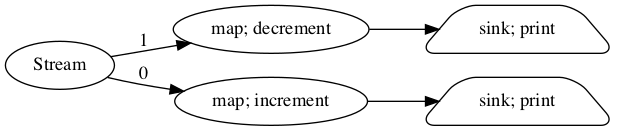

In [3]:
def increment(x):
    return x + 1

def decrement(x):
    return x - 1

source = Stream()
a = source.map(increment).sink(print)
b = source.map(decrement).sink(print)
b.visualize(rankdir='LR')

In [6]:
for i in range(5):
    source.emit(i)

1
-1
2
0
3
1
4
2
5
3


#### 流合并

+ `union(*upstreams, **kwargs)`将不同的流做合并操作

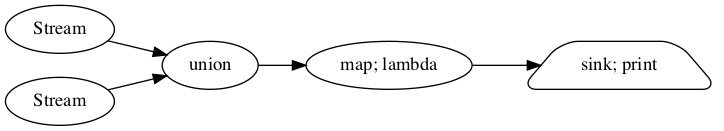

In [7]:
source1 = Stream()
source2 = Stream()
view = source1.union(source2).map(lambda x: x**2).sink(print)
view.visualize(rankdir='LR')

In [8]:
for i,j in zip(range(10),range(20,30)):
    source1.emit(i)
    source2.emit(j)

0
400
1
441
4
484
9
529
16
576
25
625
36
676
49
729
64
784
81
841


+ `combine_latest(*upstreams, **kwargs)`将不同流的最后两个元素组成tuple后合并,注意这个接口只要有一条流中有新数据传入就会触发计算

In [14]:
source1 = Stream()
source2 = Stream()
source1.combine_latest(source2).sink(print)

for i,j in zip(range(10),range(20,30)):
    source1.emit(i)
    if j%2==0:
        source2.emit(j)

(0, 20)
(1, 20)
(2, 20)
(2, 22)
(3, 22)
(4, 22)
(4, 24)
(5, 24)
(6, 24)
(6, 26)
(7, 26)
(8, 26)
(8, 28)
(9, 28)


+ `zip(*upstreams, **kwargs)`将不同流按次序对齐并组成tuple,这个行为和python默认的zip一致,只是这个接口会丢弃无法对齐的数据

In [15]:
source1 = Stream()
source2 = Stream()
source1.zip(source2).sink(print)

for i,j in zip(range(10),range(20,30)):
    source1.emit(i)
    if j%2==0:
        source2.emit(j)

(0, 20)
(1, 22)
(2, 24)
(3, 26)
(4, 28)


+ `zip_latest(lossless, *upstreams, **kwargs)`这个接口会保证所有元素都被放出来,并且最长的一条不会重

In [16]:
source1 = Stream()
source2 = Stream()
source1.zip_latest(source2).sink(print)

for i,j in zip(range(10),range(20,30)):
    source1.emit(i)
    if j%2==0:
        source2.emit(j)

(0, 20)
(1, 20)
(2, 20)
(3, 22)
(4, 22)
(5, 24)
(6, 24)
(7, 26)
(8, 26)
(9, 28)


#### 递归与反馈

`.connect(downstream)`和`.disconnect(downstream)`可以用于将流连接起来,这常用于构造递归与反馈循环,下面的例子我们构造一个流用于遍历我们的文件系统

In [9]:
from streamz import Stream
from pathlib import Path
source = Stream()

my_path = source.unique()
my_path.sink(print)

def inner_dir(x):
    p = Path(x)
    return [str(i) for i in p.iterdir()]
        
content = my_path.filter(lambda x: Path(x).is_dir())
links = content.map(inner_dir).flatten()
links.connect(source)  # pipe new links back into pages

source.emit('./')

./
分布式数据结构.ipynb
.DS_Store
mystream.png
source
source/collections-schedulers.png
README.ipynb
dask作为算力池.ipynb
code
code/.DS_Store
code/streaming
code/streaming/streaming_async.py
code/realtime
code/realtime/async_actor.py
code/realtime/.vscode
code/realtime/.vscode/settings.json
code/realtime/async_submit.py
实时任务提交.ipynb
README.md
.ipynb_checkpoints
.ipynb_checkpoints/分布式数据结构-checkpoint.ipynb
.ipynb_checkpoints/外部数据读取-checkpoint.ipynb
.ipynb_checkpoints/README-checkpoint.ipynb
.ipynb_checkpoints/流处理-checkpoint.ipynb
.ipynb_checkpoints/dask作为算力池-checkpoint.ipynb
.ipynb_checkpoints/实时任务提交-checkpoint.ipynb
mydask.png
流处理.ipynb
服务化.ipynb


## 结合dask的实时流处理

最基础的流处理就是来一条处理一条的实时处理,这种模式模型最简单,但对系统的处理能力和网络io有较高要求,往往需要更多的资源.这个模式最知名的是storm框架.我们可以结合dask作为算力池直接利用集群算力来做实时流处理.


在streamz框架下,我们使用`scatter()`接口提交计算图,使用`gather()`接收流结果

### 同步写法

In [10]:
def increment(x):
    """ A blocking increment function

    Simulates a computational function that was not designed to work
    asynchronously
    """
    time.sleep(0.1)
    return x + 1


def write(x):
    print(x)


In [11]:
from dask.distributed import Client
client = Client("localhost:8786",processes=False) 
from streamz import Stream

source = Stream()
(source.scatter()       # scatter local elements to cluster, creating a DaskStream
       .map(increment)  # map a function remotely
       .buffer(5)       # allow five futures to stay on the cluster at any time
       .gather()        # bring results back to local process
       .sink(write))    # call write locally

for x in range(10):
    source.emit(x)

1
2
3
4
5
6
7
8
9
10


### 异步写法

异步写法下,`sink`接口的参数可以是一个协程函数

In [8]:
%%writefile  code/streaming/streaming_async.py
import asyncio
import time
from dask.distributed import Client
from streamz import Stream


def increment(x):
    """ A blocking increment function

    Simulates a computational function that was not designed to work
    asynchronously
    """
    time.sleep(0.1)
    return x + 1


async def write(x):
    print(x)


async def f():
    client = await Client("localhost:8786", processes=False, asynchronous=True)
    source = Stream(asynchronous=True)
    source.scatter().map(increment).rate_limit('500ms').gather().sink(write)

    for x in range(10):
        await source.emit(x)

if __name__ == '__main__':
    asyncio.get_event_loop().run_until_complete(f())

Overwriting code/streaming/streaming_async.py


## 批处理

更加常见的场景是使用流做批处理,我们当然可以直接使用上面的数据截断缓存方法来构造批数据,然后使用python函数处理.但显然这并不高效优雅.

另一种方式则是使用streamz提供的两种流数据结构


### batch结构


batch结构用于构造由python数组组成的批数据,

In [21]:
from dask.distributed import Client
import json
from streamz import Stream
client = Client("localhost:8786",processes=False) 
stream = Stream()
example = [{'name': 'Alice', 'x': 1, 'y': 2}]
batch = stream.to_batch(example=example)
batch.stream.scatter().map(json.dumps).gather().sink(print)

batch.emit(example)

[{"name": "Alice", "x": 1, "y": 2}]


### dataframe结构,借助pandas,dask,甚至cupy

In [8]:
import pandas as pd
from streamz import Stream
from streamz.dataframe import DataFrame
stream = Stream()
df_sample = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
sdf = DataFrame(example=df_sample, stream=stream)

L = sdf.stream.scatter().map(lambda x: x["x"]**2+3).gather().sink(print)

sdf.emit(df_sample)

0     4
1     7
2    12
Name: x, dtype: int64


dataframe只能处理结构化数据,这个例子中我们首先使用pandas构造了一个dataframe的Scheme(设计方案),`df_sample`,后续的所有使用`emit`传入的dataframe就固定好了从流中解析出的是这个样式.这个例子可以看出我们可以构造数据类型`dataframe`来做批处理,但如何构造批呢?

### 将流构造为批进行批处理

我们可以一批一批的处理数据了,但流并不会自己成为批数据,这时候我们就可以使用前面提到的`截断缓存流`数据的方法构造批数据了.这边以`partition`方法为例.

下面的例子的过程如下:

1. 我们使用`partition(5)`将流截断缓存为3个一组,再将这5个一组的流转换为批对象,接着将批对象转换为dataframe,然后用dataframe的接口求取每5个的value字段的均值.这定义了流数据批处理的整个过程

2. 在构造好这个处理流程后,我们提出流程的`stream`对象,定义它的数据提交,收集和下沉过程.

3. 最后我们向流对象中喂入数据.

In [5]:
import pandas as pd
import random
from streamz import Stream
from dask.distributed import Client
from streamz.dataframe import DataFrame
# 定义流
client = Client("localhost:8786",processes=False) 
stream = Stream()

# 定义批处理过程
keys = ["a","b","c"]
batch_sample = [{'key': "a", 'value': 20}]
batch = stream.partition(5).to_batch(example=batch_sample)
sdf = batch.to_dataframe()
process = sdf.value.mean()

# 定义数据提交,收集,下沉过程
process.stream.scatter().gather().sink(print)

# 向流中注入数据
for i in range(100):
    stream.emit({"key":random.choice(keys),"value":random.randint(20,100)})

64.8
65.5
67.53333333333333
65.8
64.84
68.76666666666667
71.2
70.75
68.31111111111112
66.8
65.89090909090909
65.71666666666667
65.8
66.48571428571428
64.88
63.675
64.0
64.17777777777778
63.61052631578947
63.11
